In [18]:
%matplotlib inline

import copy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant

In [19]:
df_raw = pd.read_csv("../data/raw/power_data.csv")
df_raw

,date,symbol,open,high,low,close,Volume USDT,tradecount,token,hour,...,WMA,MACD,MACD_Signal,MACD_Hist,ATR,HMA,KAMA,CMO,Z-Score,QStick
0,2020-01-01 00:01:00,BTC/USDT,7182.43,7182.44,7178.75,7179.01,509146,140,BTC,0,...,7179.078190,0.728704,-0.152219,0.880923,4.684925,7177.563636,7178.824357,4.193879,0.620718,0.120
1,2020-01-01 00:02:00,BTC/USDT,7179.01,7179.01,7175.25,7177.93,713540,148,BTC,0,...,7179.128476,0.736887,-0.182091,0.918978,4.698380,7176.318505,7178.819894,0.859360,0.359448,0.528
2,2020-01-01 00:03:00,BTC/USDT,7177.77,7182.60,7177.00,7181.11,497793,104,BTC,0,...,7179.299905,0.846578,-0.117923,0.964501,4.609025,7175.562717,7178.843061,11.466626,1.198367,0.493
3,2020-01-01 00:04:00,BTC/USDT,7179.10,7179.10,7172.94,7175.25,698627,193,BTC,0,...,7178.981619,0.650488,-0.343494,0.993981,4.398181,7175.694414,7178.783250,-7.962104,-0.321289,-0.425
4,2020-01-01 00:05:00,BTC/USDT,7174.71,7177.14,7173.28,7175.61,241980,124,BTC,0,...,7179.421905,0.987398,-0.092457,1.079855,4.262656,7178.227646,7178.811842,-6.795307,-0.228270,-0.131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997205,2023-10-22 23:55:00,BTCUSDT,29964.99,29969.99,29964.99,29967.58,482950,635,BTC,23,...,36991.957143,-4056.925846,-1909.922487,-2147.003359,926.278065,26092.905515,30934.678406,-97.689989,-2.200250,13.189
1997206,2023-10-22 23:56:00,BTCUSDT,29967.59,29973.41,29967.58,29973.41,169682,450,BTC,23,...,38554.923714,-3657.565528,-1988.042791,-1669.522737,996.882531,27736.387869,31694.116151,-97.688910,-2.508047,24.399
1997207,2023-10-22 23:57:00,BTCUSDT,29973.40,29976.80,29973.40,29976.80,111271,303,BTC,23,...,40273.364286,-3095.229187,-1922.717147,-1172.512039,1072.856572,31258.481586,33045.458031,-97.688328,-2.950994,32.045
1997208,2023-10-22 23:58:00,BTCUSDT,29976.79,29985.00,29976.79,29984.99,169741,631,BTC,23,...,42146.929714,-2332.807178,-1640.974425,-691.832752,1154.492462,36661.349949,35372.897366,-97.687019,-3.679353,22.669


In [32]:
df = copy.deepcopy(df_raw)

df = df.drop(["symbol","token"], axis=1)

df["Evolution"] = df["close"]-df["open"]

df["variation"] = ((df["close"] - df["open"]) / df["open"]) * 100
#df["variation"] = df["variation"].map("{:.2f}%".format)

df["variation_10"] = ((df["close"] - df["open"].shift(10).fillna(df["open"].iloc[0])) / df["open"].shift(10).fillna(df["open"].iloc[0])) * 100
#df["variation_10"] = df["variation_10"].map("{:.2f}%".format)

In [33]:
df['day'] = df['day'].astype(str)

jours_dict = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

df['day'] = df['day'].map(jours_dict)


In [34]:
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()
df_clean.head()

,date,open,high,low,close,Volume USDT,tradecount,hour,day,ema_5,...,MACD_Hist,ATR,HMA,KAMA,CMO,Z-Score,QStick,Evolution,variation,variation_10
0,2020-01-01 00:01:00,7182.43,7182.44,7178.75,7179.01,509146,140,0,2,7178.557958,...,0.880923,4.684925,7177.563636,7178.824357,4.193879,0.620718,0.120,-3.42,-0.047616,-0.047616
1,2020-01-01 00:02:00,7179.01,7179.01,7175.25,7177.93,713540,148,0,2,7178.331936,...,0.918978,4.698380,7176.318505,7178.819894,0.859360,0.359448,0.528,-1.08,-0.015044,-0.062653
2,2020-01-01 00:03:00,7177.77,7182.60,7177.00,7181.11,497793,104,0,2,7178.532904,...,0.964501,4.609025,7175.562717,7178.843061,11.466626,1.198367,0.493,3.34,0.046533,-0.018378
3,2020-01-01 00:04:00,7179.10,7179.10,7172.94,7175.25,698627,193,0,2,7177.244357,...,0.993981,4.398181,7175.694414,7178.783250,-7.962104,-0.321289,-0.425,-3.85,-0.053628,-0.099966
4,2020-01-01 00:05:00,7174.71,7177.14,7173.28,7175.61,241980,124,0,2,7178.241535,...,1.079855,4.262656,7178.227646,7178.811842,-6.795307,-0.228270,-0.131,0.90,0.012544,-0.094954


Save the clean df 

In [35]:
import os
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)
df_clean.to_csv(os.path.join(output_dir, 'clean_new_df_2.csv'), index=False)

In [36]:
def get_variable_for_forward_selction(model_variables, response, data_frame, candidate_variables):
    list_of_p_values = []
    for var in candidate_variables:
        new_model_vars = model_variables + [var]
        x_matrix = add_constant(data_frame[new_model_vars])
        model = OLS(response, x_matrix)
        results = model.fit()
        list_of_p_values.append({
            'var': var, 
            'P-values': results.pvalues.iloc[-1],
        })
    df_p_values = pd.DataFrame(list_of_p_values).sort_values('P-values')
    return df_p_values['var'].iloc[0]
    

In [37]:
df.dtypes , len(df.columns)


(date             object
 open            float64
 high            float64
 low             float64
 close           float64
 Volume USDT       int64
 tradecount        int64
 hour              int64
 day               int64
 ema_5           float64
 ema_15          float64
 ema_30          float64
 ema_60          float64
 ema_100         float64
 ema_200         float64
 WMA             float64
 MACD            float64
 MACD_Signal     float64
 MACD_Hist       float64
 ATR             float64
 HMA             float64
 KAMA            float64
 CMO             float64
 Z-Score         float64
 QStick          float64
 Evolution       float64
 variation       float64
 variation_10    float64
 dtype: object,
 28)

In [38]:
df = df.select_dtypes(include=['float64',"int64"])


In [39]:
# Exclude 'day' column from conversion to float
df = df.drop(columns=['day'])
df.dtypes, len(df.columns)

(open            float64
 high            float64
 low             float64
 close           float64
 Volume USDT       int64
 tradecount        int64
 hour              int64
 ema_5           float64
 ema_15          float64
 ema_30          float64
 ema_60          float64
 ema_100         float64
 ema_200         float64
 WMA             float64
 MACD            float64
 MACD_Signal     float64
 MACD_Hist       float64
 ATR             float64
 HMA             float64
 KAMA            float64
 CMO             float64
 Z-Score         float64
 QStick          float64
 Evolution       float64
 variation       float64
 variation_10    float64
 dtype: object,
 26)

In [40]:
df.columns

Index(['open', 'high', 'low', 'close', 'Volume USDT', 'tradecount', 'hour',
       'ema_5', 'ema_15', 'ema_30', 'ema_60', 'ema_100', 'ema_200', 'WMA',
       'MACD', 'MACD_Signal', 'MACD_Hist', 'ATR', 'HMA', 'KAMA', 'CMO',
       'Z-Score', 'QStick', 'Evolution', 'variation', 'variation_10'],
      dtype='object')

Text(0.5, 0, 'Number of variables')

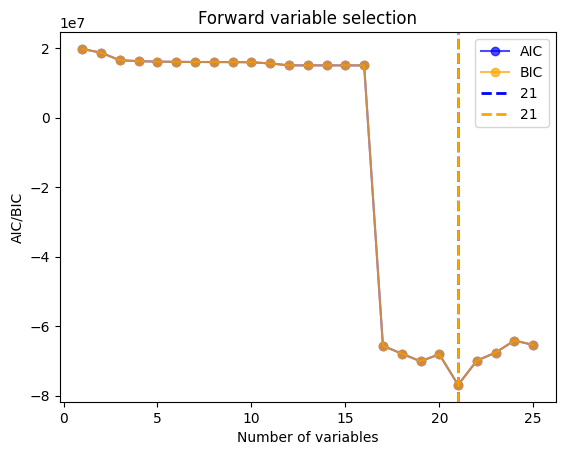

In [41]:
# Clean the dataframe by removing rows with NaNs or infinite values
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()

response = df_clean["close"]

candidate_vars = df_clean.drop(columns=["close"]).columns.tolist()
num_of_forward_steps = len(candidate_vars)

model_vars = []
results_list = []
for _ in range(num_of_forward_steps):
    selected_var = get_variable_for_forward_selction(model_vars, response, df_clean, candidate_vars)
    model_vars.append(selected_var)
    candidate_vars = [var for var in candidate_vars if var not in model_vars]
    
    x_matrix =  add_constant(df_clean[model_vars])
    model = OLS(response, x_matrix)
    results = model.fit()
    results_list.append({
        'Number of Variables': len(model_vars), 
        'Variables': model_vars.copy(), 
        'AIC': results.aic,
        'BIC': results.bic
    })
df_results = pd.DataFrame(results_list)


plt.plot(
    df_results['Number of Variables'],
    df_results['AIC'],
    'bo-',
    alpha = 0.7,
    label = "AIC"
)
plt.plot(
    df_results['Number of Variables'],
    df_results['BIC'],
    'o-',
    alpha = 0.7,
    c = 'orange',
    label = "BIC"
)

vars_AIC = df_results[df_results["AIC"]==min(df_results["AIC"])]['Variables'].tolist()[0]
vars_BIC = df_results[df_results["BIC"]==min(df_results["BIC"])]['Variables'].tolist()[0]

plt.axvline(
    len(vars_AIC), color='b', linestyle='--', linewidth=2,
    label = f"{len(vars_AIC)}"
)
plt.axvline(
    len(vars_BIC), color='orange', linestyle='--', linewidth=2,
    label = f"{len(vars_BIC)}"
)

plt.title("Forward variable selection")
plt.legend()
plt.ylabel("AIC/BIC")
plt.xlabel("Number of variables")

In [44]:
df_results.loc[21, 'Variables']

['open',
 'high',
 'low',
 'ema_5',
 'ema_15',
 'ema_30',
 'ema_60',
 'ema_100',
 'ema_200',
 'WMA',
 'MACD',
 'MACD_Signal',
 'MACD_Hist',
 'CMO',
 'KAMA',
 'Z-Score',
 'Evolution',
 'Volume USDT',
 'hour',
 'tradecount',
 'HMA',
 'ATR']

In [45]:
df_results.loc[17, 'Variables'] +["variation_10"]+["variation"]

['open',
 'high',
 'low',
 'ema_5',
 'ema_15',
 'ema_30',
 'ema_60',
 'ema_100',
 'ema_200',
 'WMA',
 'MACD',
 'MACD_Signal',
 'MACD_Hist',
 'CMO',
 'KAMA',
 'Z-Score',
 'Evolution',
 'Volume USDT',
 'variation_10',
 'variation']

In [47]:
import os

# Sélectionner les colonnes spécifiées
selected_columns = df_results.loc[21, 'Variables'] +["variation_10"]+["variation"]
df_selected = df[selected_columns]

# Créer le dossier si nécessaire
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Enregistrer la nouvelle DataFrame dans le dossier src
df_selected.to_csv(os.path.join(output_dir, 'selected_columns_2.csv'), index=False)

In [ ]:
df_selected

,open,high,low,ema_5,ema_15,ema_30,ema_60,ema_100,ema_200,WMA,MACD,MACD_Signal,MACD_Hist,HMA,Z-Score,QStick,KAMA,Evolution
0,7182.43,7182.44,7178.75,7178.557958,7178.357760,7177.701022,7179.328746,7184.279990,7194.752301,7179.078190,0.728704,-0.152219,0.880923,7177.563636,0.620718,0.120,7178.824357,-3.42
1,7179.01,7179.01,7175.25,7178.331936,7178.264583,7177.610747,7179.339551,7184.386454,7194.910516,7179.128476,0.736887,-0.182091,0.918978,7176.318505,0.359448,0.528,7178.819894,-1.08
2,7177.77,7182.60,7177.00,7178.532904,7178.312380,7177.588730,7179.387332,7184.516888,7195.081174,7179.299905,0.846578,-0.117923,0.964501,7175.562717,1.198367,0.493,7178.843061,3.34
3,7179.10,7179.10,7172.94,7177.244357,7177.912720,7177.345883,7179.328937,7184.585714,7195.221588,7178.981619,0.650488,-0.343494,0.993981,7175.694414,-0.321289,-0.425,7178.783250,-3.85
4,7174.71,7177.14,7173.28,7178.241535,7178.293109,7177.490427,7179.467206,7184.774314,7195.422307,7179.421905,0.987398,-0.092457,1.079855,7178.227646,-0.228270,-0.131,7178.811842,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997205,29964.99,29969.99,29964.99,32126.755815,38375.628878,41728.745001,43925.594454,44959.738453,45839.075354,36991.957143,-4056.925846,-1909.922487,-2147.003359,26092.905515,-2.200250,13.189,30934.678406,2.59
1997206,29967.59,29973.41,29967.58,33206.343722,39576.778718,42539.859829,44398.747486,45262.610341,45998.587870,38554.923714,-3657.565528,-1988.042791,-1669.522737,27736.387869,-2.508047,24.399,31694.116151,5.82
1997207,29973.40,29976.80,29973.40,34822.810583,40948.688535,43406.511542,44887.741977,45571.483075,46159.644934,40273.364286,-3095.229187,-1922.717147,-1172.512039,31258.481586,-2.950994,32.045,33045.458031,3.40
1997208,29976.79,29985.00,29976.79,37245.815874,42516.101182,44332.698544,45393.197638,45886.527177,46322.286592,42146.929714,-2332.807178,-1640.974425,-691.832752,36661.349949,-3.679353,22.669,35372.897366,8.20
